#### Loading train and predictions files

In [67]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.read_csv("train.csv")
df_predictions = pd.read_csv("predictions.csv")

### dropping unnamed att
df_train.drop('Unnamed: 0', axis = 1, inplace = True)
df_predictions.drop('Unnamed: 0', axis = 1, inplace = True)

### The city name should lead to bias, so let's remove it, but keep them for further analysis
citiesWithStores = df_train['CITY'].to_frame()
cityNamesPredictions = df_predictions['CITY'].to_frame()
df_train.drop('CITY', axis = 1, inplace = True)
df_predictions.drop('CITY', axis = 1, inplace = True)




In [68]:
### just to be sure
display(df_train.head())
display(df_predictions.head())
display(cityNamesPredictions.head())

,2010 Census,Land Area,Households with Under 18,Population Density,Total Families,Total Pawdacity Sales
0,4585,3115.50750,746,1.55,1819.50,185328
1,35316,3894.30910,7788,11.16,8756.32,317736
2,9520,2998.95696,1403,1.82,3515.62,218376
3,6120,1829.46510,832,1.46,1744.08,208008
4,12359,999.49710,1486,4.95,2712.64,283824


,2010 Census,Land Area,Households with Under 18,Population Density,Total Families
0,1911,853.806650,497,0.93,1040.41
1,181,7.685902,37,0.10,74.87
2,828,366.598892,213,0.40,446.72
3,440,253.240322,62,0.06,129.53
4,106,29.459830,18,0.01,33.70


,CITY
0,Afton
1,Albin
2,Alpine
3,Baggs
4,Bairoil


#### Looking at the distribution

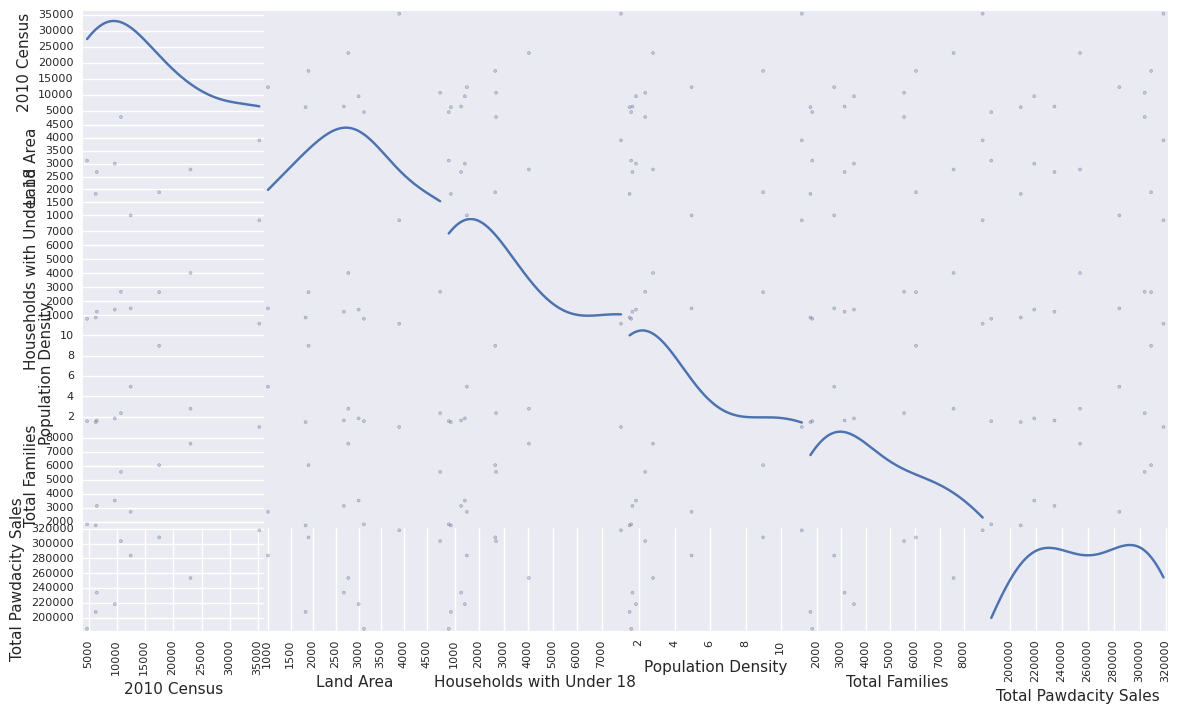

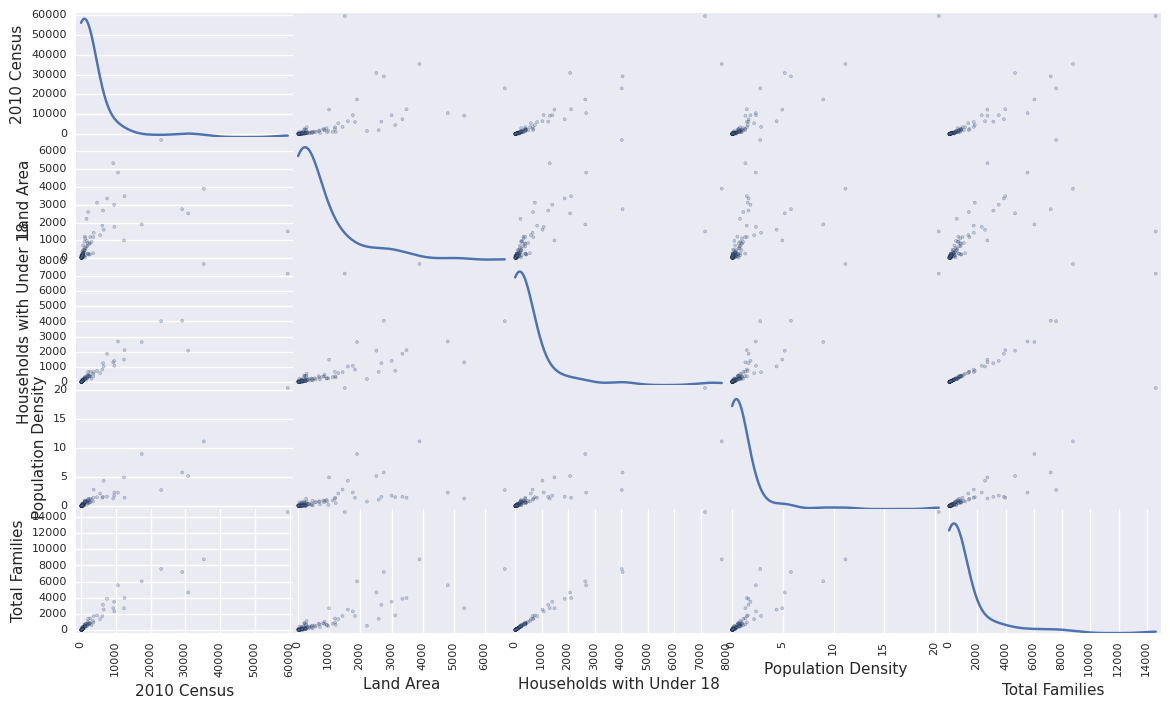

In [69]:
# df_train.drop('Land Area',axis=1,inplace=True)
# df_predictions.drop('Land Area',axis=1,inplace=True)
pd.scatter_matrix(df_train, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
pd.scatter_matrix(df_predictions, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

#### Looking for correlation amongst the variables

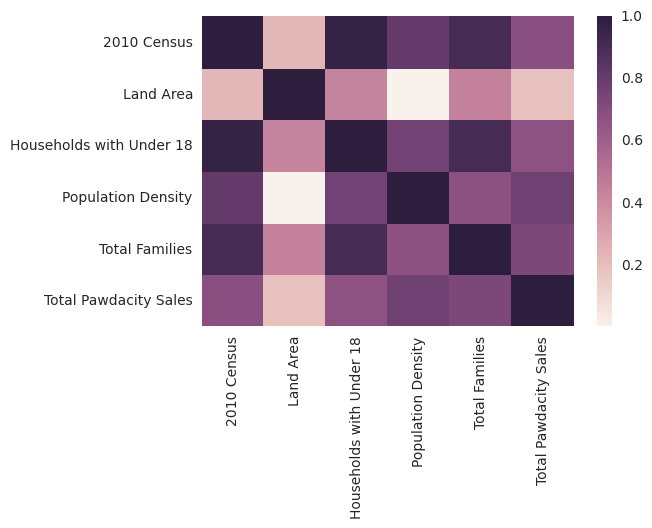

In [70]:
toRemoveCorrelation = []
df_correlation = df_train.copy()
df_correlation = df_correlation.corr().abs()

#### PLOTS THIS AS A HEATMAP
import seaborn as sns
sns.heatmap(df_correlation,
            xticklabels=df_correlation.columns.values,
            yticklabels=df_correlation.columns.values)

In [71]:
### Breaking data down into X and Y
X = df_train.drop('Total Pawdacity Sales', axis = 1)
Y = df_train['Total Pawdacity Sales']

#### SELECTING FEATURES
from sklearn.metrics import r2_score
def powerset(s):
    sets = []
    x = len(s)
    for i in range(1 << x):
        sets.append([s[j] for j in range(x) if (i & (1 << j))])
    return sets

from sklearn.linear_model import LinearRegression
bestR2 = -99999
bestSubset = []
allAtts = []
for att in X.columns.values:
    if att != "Total Pawdacity Sales":
        allAtts.append(att)
allSets = powerset(X.columns.values)
for attSet in allSets:
    if len(attSet) > 0:
        reg = LinearRegression(fit_intercept=True)
        reg.fit(X[attSet], Y)
        predictions_train = reg.predict(X[attSet])
        r2score = r2_score(predictions_train, Y)
        if r2score > bestR2:
            bestSubset = attSet
            bestR2 = r2score

print "best score = {}, obtained using {}".format(bestR2, bestSubset)
# from sklearn.feature_selection import RFE
# reg = LinearRegression()
# selector = RFE(reg)
# X = selector.fit_transform(X, Y)
# print "{} features selected".format(selector.n_features_)
# print "features selected = {} ".format(selector.support_)
# print "features selected = {} ".format(selector.ranking_)

### Normalizing both X, and df_predictions
# cols_to_norm = ['2010 Census','Land Area', 'Households with Under 18', 'Population Density', 'Total Families']
# X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))
# df_predictions[cols_to_norm] = df_predictions[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))


# pd.scatter_matrix(X, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
# pd.scatter_matrix(df_predictions, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

best score = 0.701564810816, obtained using ['2010 Census', 'Land Area', 'Households with Under 18', 'Population Density', 'Total Families']


In [72]:
#### Learning a linear model
reg = LinearRegression(fit_intercept = True)
# reg = LinearRegression()
reg.fit(X[bestSubset], Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Compute the r^2 value

In [73]:
from sklearn.feature_selection import f_regression
_, pvalues = f_regression(X[bestSubset], Y)
index = 0
for attribute in X.columns.values:
    pval = pvalues[index]
    print "{} has a p-value of {}".format(attribute, pval)
    index = index + 1



predictions_train = reg.predict(X[bestSubset])
r2score = r2_score(predictions_train, Y)
print "\n\tThe r2 score obtained during training is {:.5f}".format(r2score)
# for att in X.columns.values:
#     r2_var = r2_score(X[att], Y)
#     pval = 0.0
#     print "{} has a r2 score of {:.5f} and a p-value of {}".format(att, r2_var, pval)

2010 Census has a p-value of 0.0404993770689
Land Area has a p-value of 0.621327061156
Households with Under 18 has a p-value of 0.0466060033703
Population Density has a p-value of 0.0141989821257
Total Families has a p-value of 0.0240689813987

	The r2 score obtained during training is 0.70156


#### Printing out the equation

In [74]:
indexCoef = 0
coefficients = reg.coef_
finalEquation = "Y = "
for attribute in X.columns.values:
    coef = coefficients[indexCoef]
    finalEquation = finalEquation + "{:0.2f} * {} + ".format(float(coef), attribute)
    indexCoef = indexCoef + 1
finalEquation = finalEquation + "{0:.2f}".format(float(reg.intercept_))
print finalEquation

Y = -10.74 * 2010 Census + -17.50 * Land Area + 26.26 * Households with Under 18 + 10043.76 * Population Density + 25.12 * Total Families + 233407.99


#### Applying the model to the predictions file

In [75]:
predictions = reg.predict(df_predictions[bestSubset])
# print predictions.shape
# print cityNamesPredictions.shape
# print type(predictions)
# print type(cityNamesPredictions)
cityNamesPredictions['Predictions'] = predictions
# print cityNamesPredictions.shape
display(cityNamesPredictions.head())

,CITY,Predictions
0,Afton,246468.742967
1,Albin,235186.290095
2,Alpine,238932.058529
3,Baggs,229734.806417
4,Bairoil,233173.619974


#### Filtering results given project criteria

1. The new store should be located in a new city. That means there should be no existing stores in the new city.
2. The total sales for the entire competition in the new city should be less than 500,000

3. The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).

4. The predicted yearly sales must be over 200,000.

5. The city chosen has the highest predicted sales from the predicted set.

In [76]:
### I will need some more data here... So let's load and work on the datasets that have the info we need :)

df_demographic = pd.read_csv("demographic_data.csv")
df_demographic.drop('Unnamed: 0', axis = 1, inplace = True)
df_web_scrape = pd.read_csv("web_scrape.csv")
df_web_scrape.drop('Unnamed: 0', axis = 1, inplace = True)
df_naics = pd.read_csv("naics_data.csv")
df_naics['CITY'] = df_naics['PHYSICAL CITY NAME']
df_naics.drop('PHYSICAL CITY NAME', axis = 1, inplace = True)
df_naics.drop('Unnamed: 0', axis = 1, inplace = True)
df_naics = df_naics.groupby('CITY').sum().reset_index()

# display(df_demographic.head())
# display(df_web_scrape.head())
### time to join 'em all!
df_joined = df_demographic.join(df_web_scrape.set_index('CITY'), on = "CITY", how = "inner")
df_joined = df_joined.join(df_naics.set_index('CITY'), on = "CITY", how = "inner")
df_joined = df_joined.join(cityNamesPredictions.set_index('CITY'), on = "CITY", how = "inner")
display(df_joined.head())


,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
2,Alpine,366.598892,213,0.40,446.72,845,828,70000,238932.058529
13,Casper,3894.309100,7788,11.16,8756.32,40086,35316,210000,322515.318677
14,Cheyenne,1500.178400,7158,20.34,14612.64,62845,59466,1021000,327802.334448
24,Douglas,1829.465100,832,1.46,1744.08,6423,6120,96000,215983.462570
25,Dubois,437.073505,244,0.21,506.29,998,971,55000,236564.996957


In [77]:
df_joined.sort_values(by = "Predictions", axis=0, ascending=False, inplace=True, kind='quicksort')
display(df_joined.head())

,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
14,Cheyenne,1500.178400,7158,20.34,14612.64,62845,59466,1021000,327802.334448
13,Casper,3894.309100,7788,11.16,8756.32,40086,35316,210000,322515.318677
91,Torrington,1599.818493,1034,4.39,2548.50,6736,6501,876991,270851.495395
95,Wheatland,1430.510450,662,2.86,1754.34,3659,3627,77000,259596.949828
51,Lander,3346.809340,1870,1.63,3876.81,7642,7487,152197,257289.072020


#### Looks good enough now, so let's filter the results to match our constraints!

In [78]:
#1. The new store should be located in a new city. That means there should be no existing stores in the new city.
#2. The total sales for the entire competition in the new city should be less than 500,000
#3. The new city where you want to build your new store must have a population over 4,000 people (based upon the 2014 US Census estimate).
#4. The predicted yearly sales must be over 200,000.
#5. The city chosen has the highest predicted sales from the predicted set.
maskNewCity = (~df_joined['CITY'].isin(citiesWithStores))
maskTotalSalesCompetition = (df_joined['SALES VOLUME'] < 500000)
maskPopulation = (df_joined['2014 Estimate'] > 4000)
maskYearlySales = (df_joined['Predictions'] > 200000)
df_masked = df_joined.loc[maskNewCity & maskTotalSalesCompetition & maskPopulation & maskYearlySales] #  
display(df_masked)

,CITY,Land Area,Households with Under 18,Population Density,Total Families,2014 Estimate,2010 Census,SALES VOLUME,Predictions
13,Casper,3894.309100,7788,11.16,8756.32,40086,35316,210000,322515.318677
51,Lander,3346.809340,1870,1.63,3876.81,7642,7487,152197,257289.072020
29,Evanston,999.497100,1486,4.95,2712.64,12190,12359,89000,240056.818999
96,Worland,1294.105755,595,2.18,1364.32,5366,5487,169000,223619.352075
24,Douglas,1829.465100,832,1.46,1744.08,6423,6120,96000,215983.462570
45,Jackson,1757.659200,1078,2.36,2313.08,10449,9577,182000,209903.156212
